## Содержание

<a id="назад"></a>
- [Постановка задачи](#Постановка)
- [Описание файла с данными](#)
- [Оценка данных](#Оценка)
    - [Поиск дубликатов](#Поиск_дубликатов)
    - [Пропущенные значения](#Пропуски)
- [Анализ](#Анализ)
    - [Жизненный цикл](#Цикл)
    - [Поколение 2013-2016](#Поколение)
    - [Предпочтения пользователей различных платформ](#Предпочтения_платформ)
    - [Влияние критиков](#Влияние_критиков)
    - [Предпочтения по регионам](#Предпочтения_регионов)
    - [Проверка гипотез](#Проверка)
- [Выводы](#Выводы)




<a id="Постановка"></a>
## [Постановка задачи](#Содержание)  
В данном проекте необходимо провести исследование рынка видеоигр. В нашем распоряжении данные о продажах на различных платформах с 1980 до 2016 года. Необходимо понять, что на данный момент пользуется спросом на разных платформах и в разных регионах, а также чего ожидать от 2017 года.

## [Описание файла с данными](#Содержание)

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.  

Данные за 2016 год могут быть неполными.

## [Оценка данных](#Содержание)
Импортируем необходимые библиотеки и загрузим файл с данными.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as st
df=pd.read_csv('games.csv')
df.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
15793,Clover no Kuni no Alice: Wonderful Wonder World,PSP,2011.0,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN
7321,NCAA March Madness 08,X360,2007.0,Sports,0.20,0.00,0.00,0.02,69.0,tbd,E
8662,Culdcept,3DS,2012.0,Misc,0.00,0.00,0.16,0.00,NaN,NaN,NaN
6202,Yu-Gi-Oh! World Championship 2008,DS,2007.0,Strategy,0.13,0.02,0.12,0.01,NaN,NaN,NaN
16223,Tears to Tiara: Kakan no Daichi Portable,PSP,2010.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Приведем названия столбцов к нижнему регистру и добавим очевидно необходимый столбец суммарных продаж:

In [3]:
df.columns=df.columns.str.lower()
df.sample(5)
df['world_sales']=df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']

Переведем столбец `user_score` в тип *float*. Значения tbd (to be determined) в столбце будут заменены на `NaN`

In [4]:
df['user_score']=pd.to_numeric(df['user_score'], errors='coerce')

Приведем столбец c годом релиза в формат даты:

In [5]:
# заменим значения NaN на -9999 (в целом типе нет NaN)
df['year_of_release']=df['year_of_release'].fillna(-9999)
# переведем в int
df['year_of_release']=df['year_of_release'].astype(int)
# переведем в datetime
df['year_of_release']=pd.to_datetime(df['year_of_release'], format='%Y', errors='coerce')

<a id="Поиск_дубликатов"></a>
### [Поиск дубликатов](#содержание)
Проверим DataFrame на наличие дубликатов:

In [6]:
print('Количество дублирующихся строк: ',df.duplicated().sum())

Количество дублирующихся строк:  0


Приведем названия игр к нижнему регистру и проделаем операцию вновь, учитывая только название и платформу:

In [7]:
df['name']=df['name'].str.lower()
print('Количество дублирующихся строк: ',df[['name','platform']].duplicated().sum())

Количество дублирующихся строк:  5


In [8]:
list_name=list(df[df[['name','platform']].duplicated()]['name'].unique())
df.query('name in @list_name').sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
16230,madden nfl 13,PS3,2012-01-01,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E,0.01
7066,madden nfl 13,WiiU,2012-01-01,Sports,0.21,0.00,0.00,0.02,75.0,6.7,E,0.23
507,madden nfl 13,X360,2012-01-01,Sports,2.53,0.15,0.00,0.17,81.0,5.8,E,2.85
604,madden nfl 13,PS3,2012-01-01,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E,2.56
5887,madden nfl 13,PSV,2012-01-01,Sports,0.28,0.00,0.00,0.02,63.0,7.3,E,0.30
3986,madden nfl 13,Wii,2012-01-01,Sports,0.47,0.00,0.00,0.03,NaN,7.3,E,0.50
6473,need for speed: most wanted,GBA,2005-01-01,Racing,0.19,0.07,0.00,0.00,NaN,8.3,E,0.26
6410,need for speed: most wanted,DS,2005-01-01,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E,0.27
6273,need for speed: most wanted,WiiU,2013-01-01,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN,0.27
5972,need for speed: most wanted,PC,2005-01-01,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T,0.29


Случаи единичны и не смогут значительно испортить нам статистику - ремастер гонок из 2012 года с PS3, платформер из 2006 и строчка-дубликат с почти нулевыми продажами на PS3 для спортивного симулятора.
Есть вероятность, что есть и другие дубликаты - например в названии игры может быть указана римская 'II', а в дубликате '2'. Но беглый просмотр известных долгоиграющих франшиз вроде assassin's creed, fallout или battlefield этой проблемы не выявил. Зато куда корректнее, видимо, именовать содержимое столбца `name` не играми, а продуктами, т.к. в ней содержатся данные как по оригинальным играм, так и по переизданиям (например антология *fallout*) и аддонам (например *world of warcraft: the burning crusade*).

<a id="Пропуски"></a>
### [Пропущенные значения](#содержание)
Посмотрим, какую часть значений составляют пропуски:

In [9]:
df.isna().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.545917
rating             0.404786
world_sales        0.000000
dtype: float64

Доли процента не имеют информации о названии и жанре продука. Для 1-2% неизвестен год релиза. И примерно в каждом втором случае есть пропуски в оценке критиков, пользователей или информации о возрастном рейтинге. Критичных проблем, кажется, нет. Посмотрим, отличается ли процент пропусков для более свежих данных. Посмотрим данные после 2013 года (релиз наиболее современных консолей в списке - PS4 и Xbox One):

In [10]:
df.query('(year_of_release>=2013)').isna().mean()

name               0.000000
platform           0.000000
year_of_release    0.000000
genre              0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.556202
user_score         0.466189
rating             0.437528
world_sales        0.000000
dtype: float64

Пропусков в названиях нет. Но и процент пропусков в столбцах оценки игроков и критиков подрос на 1-3 процентных пункта. Можно предположить, что оценка отсутствует у продуктов, которые затратили мало ресурсов на рекламную компанию, не привлекли особенного внимания и скорее всего не слишком хорошо продались. Оценим продажи по Северной Америке:

In [11]:
df.query('year_of_release>=2013')[['na_sales','eu_sales','jp_sales']].describe()

,na_sales,eu_sales,jp_sales
count,2233.000000,2233.000000,2233.000000
mean,0.196019,0.175652,0.063045
std,0.547730,0.512451,0.233997
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.020000,0.030000,0.010000
75%,0.150000,0.130000,0.050000
max,9.660000,9.090000,4.350000


Судя по всему, распределение имеет большой перекос и четверть игр продалась с показателями ниже различимых. Медианой является 10~30 тыс копий в зависимости от региона. Посмотрим, у какого количества игр с релизом после 2012 года и продавшихся тиражом в полмиллиона копий хотя бы в одном регионе, отсутствует информация об оценках критиков и пользователей:

In [12]:
df.query('(year_of_release>=2013) and ((na_sales>=0.5) or (na_sales>=0.5) or (jp_sales>=0.5))').isna().mean()

name               0.000000
platform           0.000000
year_of_release    0.000000
genre              0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.300412
user_score         0.209877
rating             0.197531
world_sales        0.000000
dtype: float64

По более продаваемым проектам информации закономерно оказывается больше. Заполнять пропуски медианой/средним или каким-то специфическим значением не будем. Значение `NaN` достаточно удобно для обозначения отсутствующих данных.

## [Анализ](#Содержание)
Подготовим пару функций для построения диаграмм:

In [13]:
#------------------------df_col_rating--------------------------------------------------------------------------
# функция df_col_rating для построения диаграммы рейтинга параметра в dataframe:
# dframe - dataframe
# col_name - столбец по которому будет составлен рейтинг
# x_name - название оси x
# y_name - название оси y
# title - название диаграммы
def df_col_rating(dframe, col_name, x_name='', y_name='', title='', sales='world_sales'):
    dframe.groupby(col_name)[sales].sum().sort_values().plot(kind='barh',figsize=(8,0.4*len(dframe[col_name].unique())),grid=True)
    plt.title(title,fontsize=16)
    plt.xlabel(x_name,fontsize=16)
    plt.ylabel(y_name,fontsize=16)
    plt.show()
#------------------------sales_platform--------------------------------------------------------------------------
# функция sales_platform для построения диаграммы суммарных продаж в регионе для игровых платформ по годам:
# list_platform - список платформ. пример ('PS','PS2','PS3')
# region_index - NA, EU или JP
# limitx - интервал оси x (по-умолчанию 1985-2017)
# limity - интервал оси y (по-умолчанию 0-220)
def sales_platform(list_platform,region_index,limitx=(1990,2016),limity=(0,220)):
    plt.figure(figsize=(10,6))
    if region_index=='NA':
        region='na_sales'
    elif region_index=='EU':
        region='eu_sales'
    elif region_index=='JP':
        region='jp_sales'
    elif region_index=='WORLD':
        region='world_sales'
    else:
        return('index not in the database')
    
    for platform_name in list_platform:
        df.query('platform==@platform_name').groupby('year_of_release')[region].sum().plot(grid=True,ylim=limity,
                                                                                           xlim=(pd.to_datetime(limitx[0],format='%Y'),
                                                                                                 pd.to_datetime(limitx[1],format='%Y')))
    plt.legend(list_platform, fontsize=16)
    plt.title('Регион: '+region_index,fontsize=16)
    plt.xlabel('Год',fontsize=16)
    plt.ylabel('Продажи в млн копий',fontsize=16)
    plt.show()

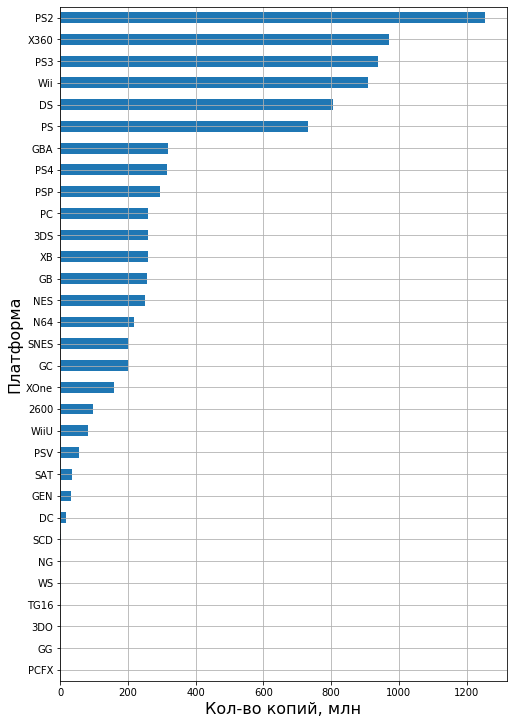

In [14]:
df_col_rating(df, 'platform', 'Кол-во копий, млн', 'Платформа')

Построим ящик с усами для пролаж на каждой минимально интересной платформе:

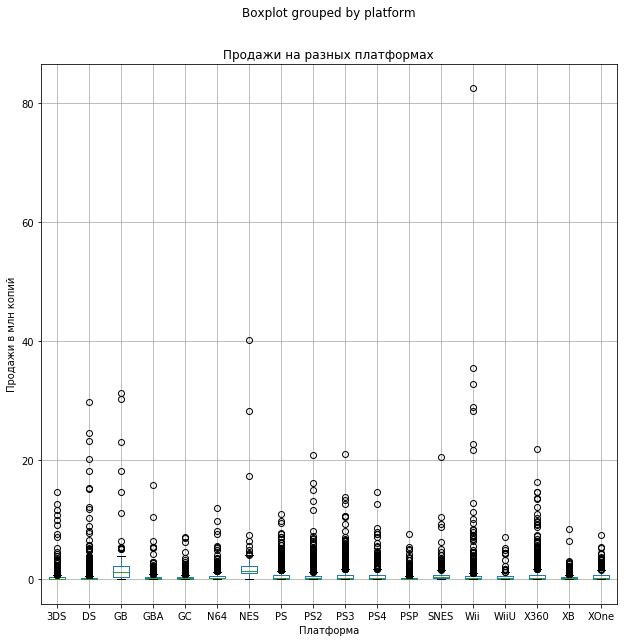

In [15]:
list_name=('PS','PSP','PS2','PS3','PS4',
           'XB','X360','XOne',
           'Wii','WiiU','GB','GC','GBA','DS','3DS','NES','SNES','N64')
df.query('platform in @list_name').boxplot(column='world_sales',by='platform',figsize=(10,10))
plt.xlabel('Платформа')
plt.ylabel('Продажи в млн копий')
plt.title('Продажи на разных платформах')
plt.show()

То, что является выбросами на диаграмме - действительно коммерчески успешные проекты. Посмотрим например, что за проект продался таким сумасшедшим тиражом на платформе Wii:

In [16]:
df.query('platform=="Wii" and world_sales>50')[['name','year_of_release','genre','world_sales']]

,name,year_of_release,genre,world_sales
0,wii sports,2006-01-01,Sports,82.54


Для успокоения поищем информацию об игре [Wii Sports](https://lenta.ru/news/2009/01/05/wiisports/) и без труда находим новость января 2009 года:
>**Wii Sports стала самой продаваемой видеоигрой**  
Сборник Wii Sports стал самым продаваемым проектом за всю историю видеоигр, сообщает VGChartz. Для достижения этой цели компании Nintendo потребовалось 110 недель. Согласно данным, которыми располагают журналисты, во всем мире продано уже свыше 40,24 миллиона копий Wii Sports. Напомним, что игра поставляется в комплекте с консолью Wii во всех регионах, за исключением Японии и Южной Кореи.  
Как отмечают журналисты, проект Wii Sports смог обогнать по количеству проданных копий платформер Super Mario Bros., который вышел в 1985 году на NES. Напомним, что эта игра также поставлялась в комплекте с приставкой. Всего в мире было реализовано почти 62 миллиона NES. Согласно данным VGChartz, продажи Wii к настоящему моменту превысили отметку в 45 миллионов консолей. Отметим, что компания Nintendo пока официально не подтвердила эту информацию.  
Проект Wii Sports представляет собой набор мини-игр, в котором геймерам предлагается управлять своим персонажем, размахивая контроллерами Wii Remote и Nunchuck. Всего на выбор предлагается пять видов спорта: бейсбол, бокс, боулинг, гольф и теннис.

Как видно на момент декабря 2016 года, рекорд всё ещё не побит. Взглянем внимательнее на наиболее свежие консоли.

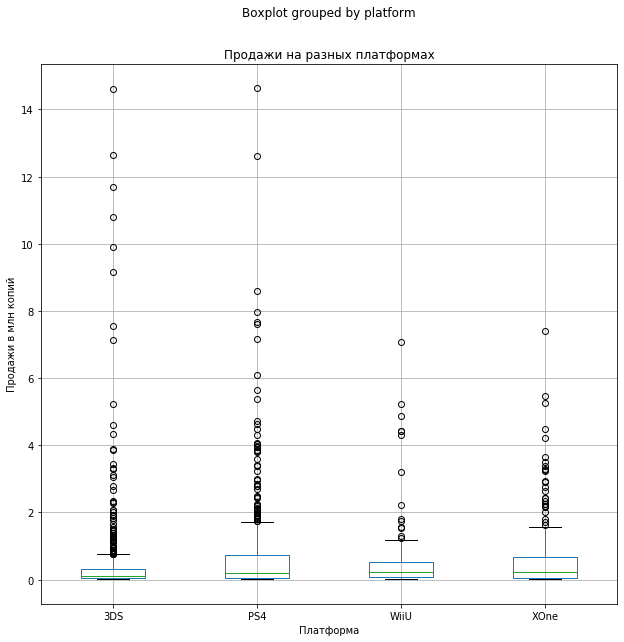

In [17]:
list_name=('PS4','XOne','WiiU','3DS')
df.query('platform in @list_name').boxplot(column='world_sales',by='platform',figsize=(10,10))
plt.xlabel('Платформа')
plt.ylabel('Продажи в млн копий')
plt.title('Продажи на разных платформах')
plt.show()

Посмотрим, каково распределение по жанрам среди всех игр за весь отчетный период:

Text(0, 0.5, 'Жанр')

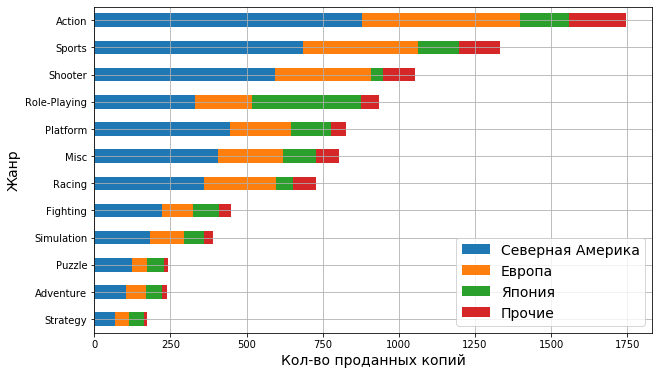

In [18]:
df_by_reg=df.groupby(['genre']).sum().sort_values(by='world_sales')[['na_sales','eu_sales','jp_sales','other_sales']]
df_by_reg.plot(kind='barh', stacked=True, grid=True, figsize=(10,6))
plt.legend(('Северная Америка','Европа','Япония','Прочие'), fontsize=14)
plt.xlabel('Кол-во проданных копий', fontsize=14)
plt.ylabel('Жанр', fontsize=14)

На первом месте по продажам жанры *Action*, *Sports* и *Shooter*. В глаза бросается очевидное наличие региональной специфики - например в NA лучшие продажи в жанре Action, а в Японии - Role-Playing. Разберем этот вопрос чуть ниже.

Напоследок оценим общую динамику индустрии:

Text(0, 0.5, 'Кол-во проданных копий, млн')

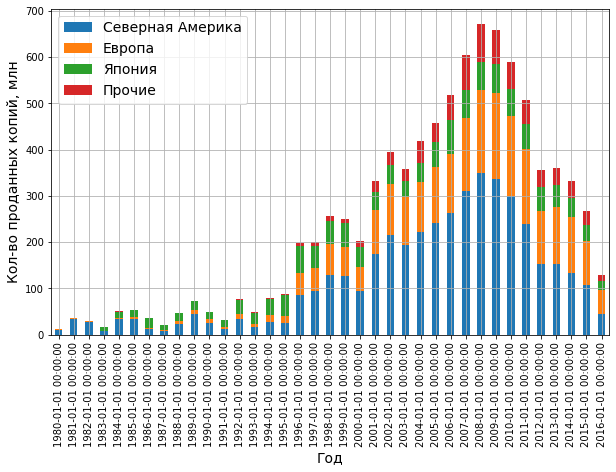

In [19]:
df_by_year=df.groupby(['year_of_release']).sum()[['na_sales','eu_sales','jp_sales','other_sales']]
df_by_year.plot(kind='bar', stacked=True, grid=True, figsize=(10,6))
plt.legend(('Северная Америка','Европа','Япония', 'Прочие'), fontsize=14)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Кол-во проданных копий, млн', fontsize=14)

Построим также график кол-ва релизов по годам:

Text(0, 0.5, 'Кол-во вышедших игр')

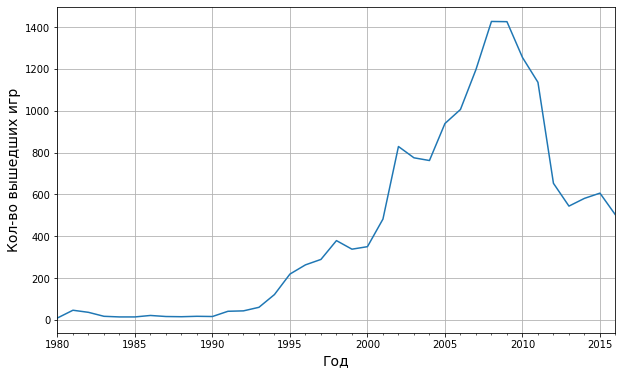

In [20]:
df.groupby('year_of_release')['name'].count().plot(grid=True,figsize=(10,6))
plt.xlabel('Год', fontsize=14)
plt.ylabel('Кол-во вышедших игр', fontsize=14)

По графикам становится довольно очевидно, что расцвет розничных продаж видеоигр остался позади. С чем это связано? Расцвет индустрии приходится на 2006-2011 года (релиз Xbox 360 и PS3 состоялся в 2005-2007 годах). Что знакового произошло в этот период? [Ипотечный кризис в США](https://ru.wikipedia.org/wiki/%D0%98%D0%BF%D0%BE%D1%82%D0%B5%D1%87%D0%BD%D1%8B%D0%B9_%D0%BA%D1%80%D0%B8%D0%B7%D0%B8%D1%81_%D0%B2_%D0%A1%D0%A8%D0%90_(2007)) 2007 года, последовавший за ним финансовый кризис и мировой экономический кризис.    
У многих домохозяйств упали доходы, а игры доступный способ проведения досуга. Покупатель получал ~50 часов геймплея заплатив цену нескольких билетов в кинотеатр. Но снижение доходов сделало покупателей более осмотрительными и мы видим, как после 2009 года количество релизов резко сокращается — на рынке выживают крупные студии, имеющие резерв.  
Примерно в этот же период набирают популярность интернет-проекты, распространяемые по схеме [Free-to-play](https://ru.wikipedia.org/wiki/Free-to-play), а проекты крупных студий всё чаще практикуют продажу [DLC](https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%B3%D1%80%D1%83%D0%B6%D0%B0%D0%B5%D0%BC%D1%8B%D0%B9_%D0%BA%D0%BE%D0%BD%D1%82%D0%B5%D0%BD%D1%82) — часто это позволяет им продать проект конечному потребителю по частям за большие деньги.

<a id="Цикл"></a>
### [Жизненный цикл](#содержание)
Построим графики для линеек консолей и оценим продажи игр с ними по миру.

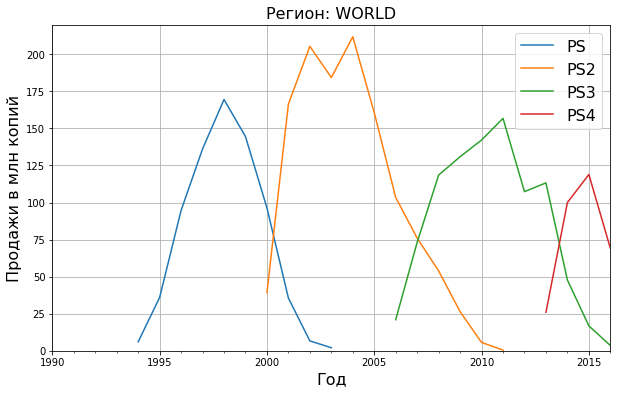

In [21]:
sales_platform(('PS','PS2','PS3','PS4'),'WORLD')

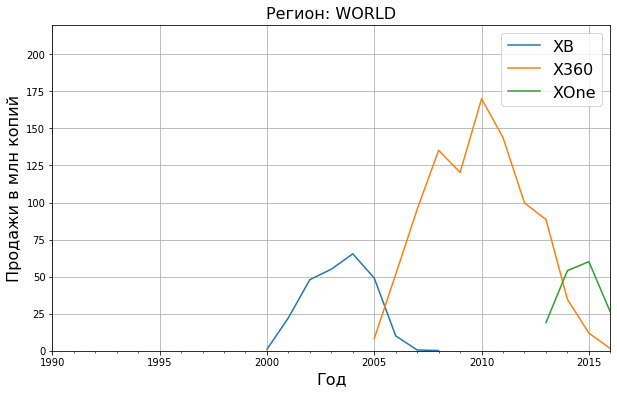

In [22]:
sales_platform(('XB','X360','XOne'),'WORLD')

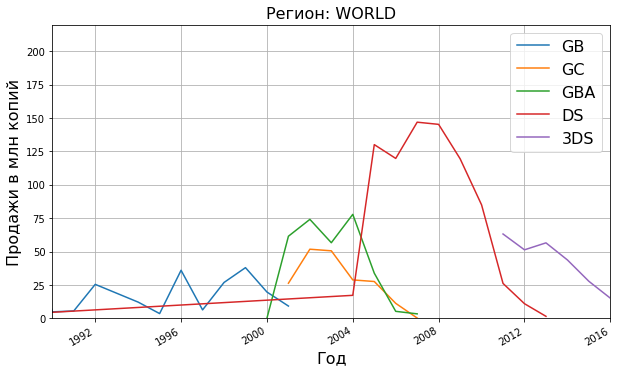

In [23]:
sales_platform(('GB','GC','GBA','DS','3DS'),'WORLD')

In [24]:
# выпавшая точка: игра на DS с релизом до релиза DS
y=pd.to_datetime('2000')
df.query('year_of_release<@y and platform=="DS"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
15957,strongest tokyo university shogi ds,DS,1985-01-01,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN,0.02


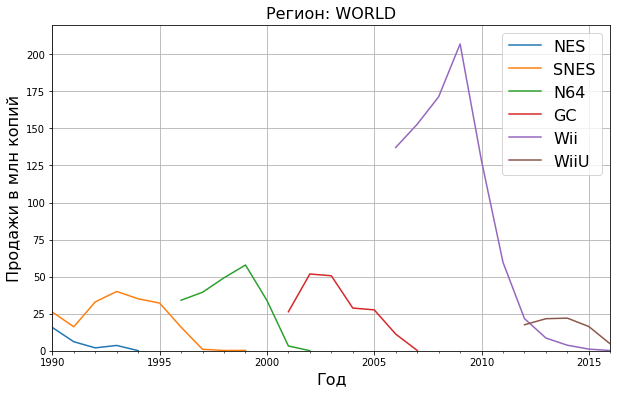

In [25]:
sales_platform(('NES','SNES','N64','GC','Wii','WiiU'),'WORLD')

Как видно из графиков, продажи игр на консолях подвержены некоторой цикличности. На старте есть небольшой пул уже готовых игр, которые покупают вместе с консолью, но примерно через год после релиза кол-во проданных игр возрастают до пиковых значений. Затем следует период активной разработки, в который на рынок выходит большое количество игр продающихся максимальным суммарным тиражом. В этот период выходят новые модели с чуть лучшими характеристиками или формфактором (например *PS4 Slim* и *PS4 Pro* в 2016). А затем наступает быстрый спад.   
Вероятно это связано с появлением официальных/неофициальных сообщений о разработке нового поколения консоли. Учитывая, что с выходом нового поколения происходит отток аудитории старого - разработчики совершенно не заинтересованы производить продукт для устаревшей верссии консоли.  
Кроме того можно отметить, что рынок самих консолей достаточно сильно монополизирован и основные конкруренты на данный момент *Microsoft* и *Sony Interactive Entertainment, LLC*. Как следствие, даже конкурируя между собой они вынужденно синхронизируют выход нового поколения консолей. Выпустить консоль раньше конкурента значит выпустить консоль с худшими характеристиками и упустить прибыль от старой (ведь пользователи всё ещё готовы были бы покупать игры, которые разработчики чаще всего выпускают для обеих консолей), а выпустить сильно позже - пользователи уйдут на другую платформу на следующие 3-5 лет витка цикла.

<a id="Поколение"></a>
### [Поколение 2013-2016](#Содержание)

Рассмотрим лидеров по продажам в период с 2013 года - выход консолей Xbox One и PS4.

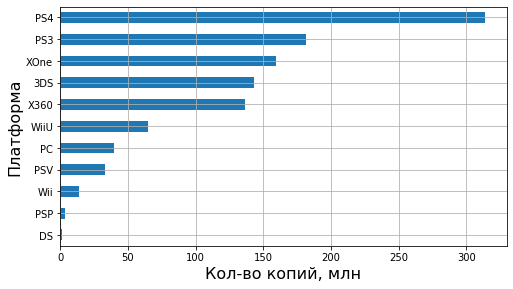

In [26]:
df_col_rating(df.query('2013<=year_of_release'), 'platform', 'Кол-во копий, млн', 'Платформа')

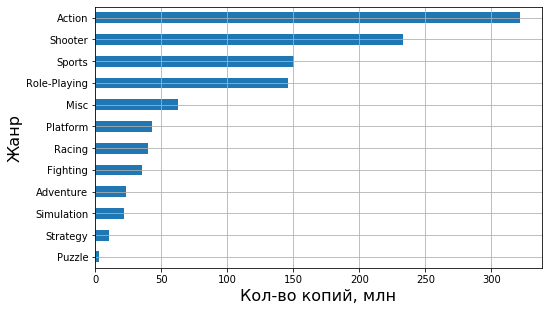

In [27]:
df_col_rating(df.query('2013<=year_of_release'), 'genre', 'Кол-во копий, млн', 'Жанр')

В лидерах ожидаемо *PS4* и *Xbox One*. Немного удивляет, что свежую консоль *Microsoft* обошла *PS3*. Вероятно играют роль конкуретное преимущество *Sony* - игры, вышедшие только на этой консоли (например *God of War III* или *Lust of Us*). Следующей за ними в рейтинге *Nintendo 3DS* - единственная современная портативная консоль на рынке.

<a id="Предпочтения_платформ"></a>
### [Предпочтения пользователей различных платформ](#Содержание)

Рассмотрим предпочтения пользователей на различных консолях

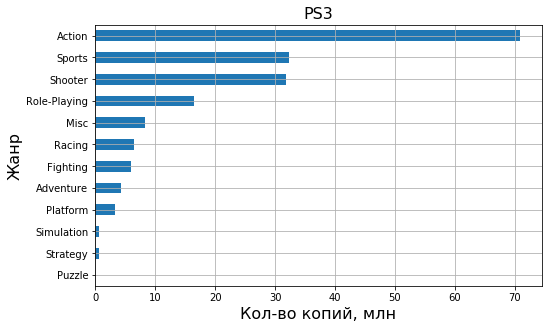

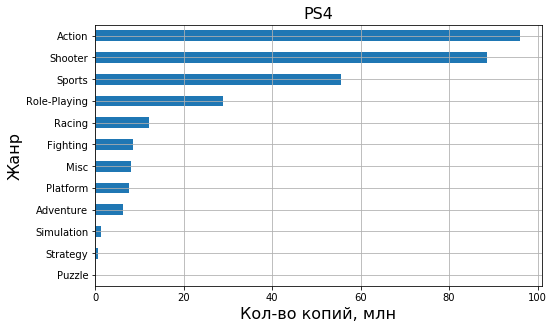

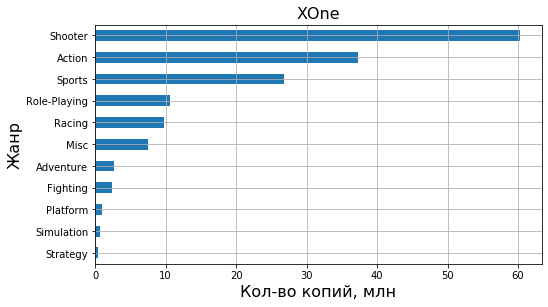

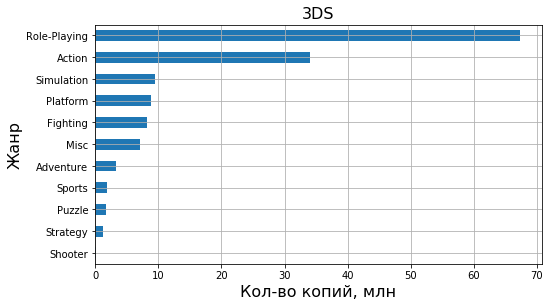

In [28]:
list_name=('PS3','PS4','XOne','3DS')
for i in list_name:
    df_col_rating(df.query('2013<=year_of_release and platform==@i'), 'genre', 'Кол-во копий, млн', 'Жанр',i)

На *PlayStation 4* и *Xbox One* в топ-3 *Action, Shooter* и *Sport*.  
На портативной консоли *Nintendo 3DS* спросом пользовались *Role-Playing* и *Action*.
Рассмотрим игры, которые разошлись в мире тиражом более 5 млн копий:

In [29]:
df1=df.query('(platform=="PS4" or platform=="XOne" or platform=="3DS" or platform=="WiiU") and world_sales>5').sort_values(by=['platform','world_sales'],ascending=False)
df1=df1[['name','platform','genre','na_sales','eu_sales','jp_sales','other_sales','world_sales']]
df1.columns=[['Название','Платформа','Жанр','NA','EU','JP','Other','Продажи, млн']]
df1.reset_index(drop=True)

,Название,Платформа,Жанр,NA,EU,JP,Other,"Продажи, млн"
0,call of duty: black ops 3,XOne,Shooter,4.59,2.11,0.01,0.68,7.39
1,grand theft auto v,XOne,Action,2.81,2.19,0.00,0.47,5.47
2,call of duty: advanced warfare,XOne,Shooter,3.22,1.55,0.01,0.48,5.26
3,mario kart 8,WiiU,Racing,3.15,2.15,1.28,0.51,7.09
4,new super mario bros. u,WiiU,Platform,2.30,1.34,1.27,0.32,5.23
5,call of duty: black ops 3,PS4,Shooter,6.03,5.86,0.36,2.38,14.63
6,grand theft auto v,PS4,Action,3.96,6.31,0.38,1.97,12.62
7,fifa 16,PS4,Sports,1.12,6.12,0.06,1.28,8.58
8,star wars battlefront (2015),PS4,Shooter,2.99,3.49,0.22,1.28,7.98
9,call of duty: advanced warfare,PS4,Shooter,2.81,3.48,0.14,1.23,7.66


Если внимательно взглянуть на таблицу, то можно отметить, что на платформе PS4 в топе среди прочих находится серия игр *FIFA* от *Electronic Arts*. Хорошие продажи показали *FIFA 15*, *FIFA 16* и *FIFA 17*. А если ещё немного пристально на них посмотреть, то выяснится, что столь высокие суммарные продажи — почти целиком заслуга европейского региона.
Лучше всего на портативной консоли Nintendo продаются их эксклюзивы (франшизы *Pokemon*, *Mario*, *Animal crossing*).

<a id="Влияние_критиков"></a>
### [Влияние критиков](#Содержание)

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.

In [30]:
df_for_score=df[['user_score','critic_score','world_sales']].copy()
df_for_score['user_score']=pd.to_numeric(df['user_score'], errors='coerce')
df_for_score.corr().style.background_gradient(cmap='RdBu_r')

,user_score,critic_score,world_sales
user_score,1.000000,0.580878,0.088179
critic_score,0.580878,1.000000,0.245507
world_sales,0.088179,0.245507,1.000000


А если взять игры с заметным тиражом? (выбросы на ящике с усами)

In [31]:
df_for_score=df.query('world_sales>2')[['user_score','critic_score','world_sales']].copy()
df_for_score['user_score']=pd.to_numeric(df['user_score'], errors='coerce')
df_for_score.corr().style.background_gradient(cmap='RdBu_r')

,user_score,critic_score,world_sales
user_score,1.000000,0.417374,0.023176
critic_score,0.417374,1.000000,0.104700
world_sales,0.023176,0.104700,1.000000


А за период 2013-2016?

In [32]:
df_for_score=df.query('2013<=year_of_release')[['user_score','critic_score','world_sales']].copy()
df_for_score.corr().style.background_gradient(cmap='RdBu_r')


,user_score,critic_score,world_sales
user_score,1.000000,0.502221,-0.002608
critic_score,0.502221,1.000000,0.313700
world_sales,-0.002608,0.313700,1.000000


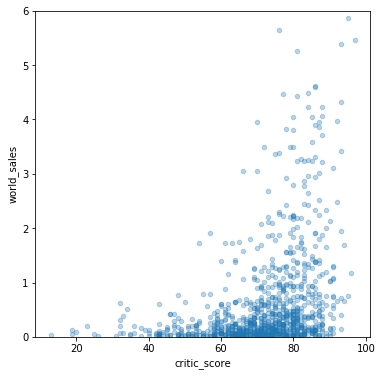

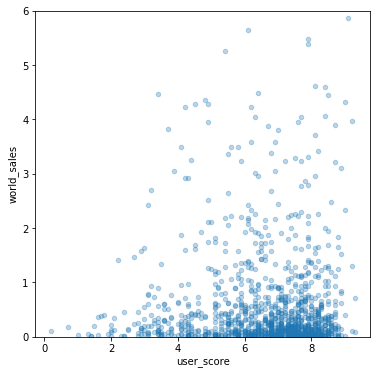

In [33]:
df_for_score.plot.scatter(x='critic_score',y='world_sales',alpha=0.3,figsize=(6,6),ylim=(0,6))
df_for_score.plot.scatter(x='user_score',y='world_sales',alpha=0.3,figsize=(6,6),ylim=(0,6))

Похоже, серьезной корреляции между продажами и оценками пользователей или критиков не наблюдается. Даже игры с весьма низкими оценками умудряются кое-как продаваться, а игры с впечатляющим коммерческим успехом лежат в широком диапазоне от 60 до 95. А с оценками игроков всё ещё неопределеннее.

<a id="Предпочтения_регионов"></a>
### [Предпочтения по регионам](#Содержание)

Посмотрим, где игры в последнее время продаются лучше:

In [34]:
df_sum_2013=df.query('2013<=year_of_release')[['na_sales','eu_sales','jp_sales']].sum()
df_sum_2013.index=['Северная Америка','Европа','Япония']
df_sum_2013

Северная Америка    437.71
Европа              392.23
Япония              140.78
dtype: float64

Как видно, Северная Америка и Европа довольно близки. Япония сильно отстает (очевидно из-за меньшего населения).  
Население Северной Америки ~579 млн, Европы ~740 млн, а население Японии ~126 млн. Посмотрим, сколько копий игр приходится на одного жителя соответствующего региона:
- В **Северной Америке** на одного человека **0.76** копии
- В **Европе** на одного человека **0.53** копии
- В **Японии** на одного человека **1.12** копии  
  
Похоже, несмотря на меньшие абсолютные продажи, скупают игры в Японии охотнее.  
Выведем топ-5 платформ по продажам в каждом регионе и построим графики:

In [35]:
def top_5(region):
    display(region[:2])
    display(df.query('2013<=year_of_release').groupby('platform')[region].sum().sort_values(ascending=False).head(5))
top_5('na_sales')
top_5('eu_sales')
top_5('jp_sales')

'na'

platform
PS4     108.74
XOne     93.12
X360     81.66
PS3      63.50
3DS      38.20
Name: na_sales, dtype: float64

'eu'

platform
PS4     141.09
PS3      67.81
XOne     51.59
X360     42.52
3DS      30.96
Name: eu_sales, dtype: float64

'jp'

platform
3DS     67.81
PS3     23.35
PSV     18.59
PS4     15.96
WiiU    10.88
Name: jp_sales, dtype: float64

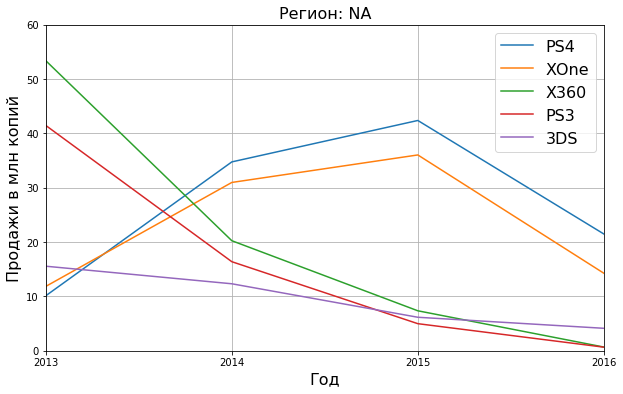

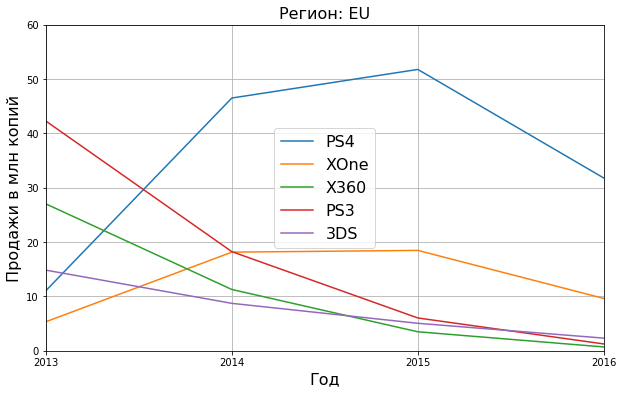

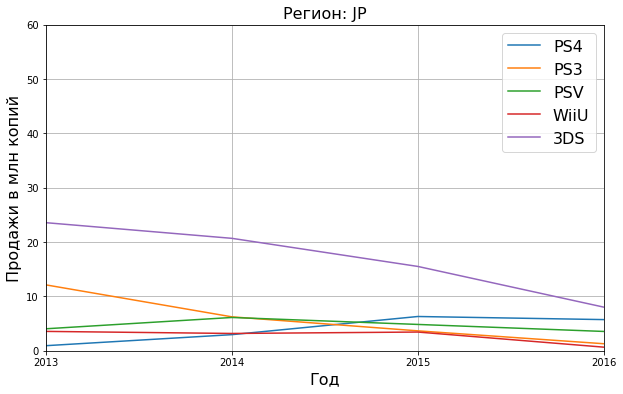

In [36]:
sales_platform(('PS4','XOne','X360','PS3','3DS'),'NA',(2013,2016),(0,60))
sales_platform(('PS4','XOne','X360','PS3','3DS'),'EU',(2013,2016),(0,60))
sales_platform(('PS4','PS3','PSV','WiiU','3DS'),'JP',(2013,2016),(0,60))

На графике хорошо видно, что к 2016 году жизненный цикл PS3 и Xbox 360 подошел к концу. А вот игры для Xbox One, PS4 и Nintendo 3DS продолжат выходить и продаваться ещё минимум 2017-2018 года.
- **Северная Америка**: продажи на платформах **PlayStation 4 и Xbox One** довольно близки, хотя PS4 
- **Европа**: **PlayStation 4** в лидерах, а Xbox отстает почти вдвое
- **Япония**: лидером является портативная консоль **Nintendo 3DS**, а вот игры на Xbox One почти не продаются

Очевидно, что не для европейского региона стоит сосредоточиться на продуктах под PS4. На американском рынке PS4 так же пользуется спросом, но и Xbox One игнорировать было бы глупо. Японская специфика заставляет уделить внимание PlayStation 4 и Nintendo 3DS. Рассмотрим предпочтительные жанры для игр в регионах для интересующих нас консолей:

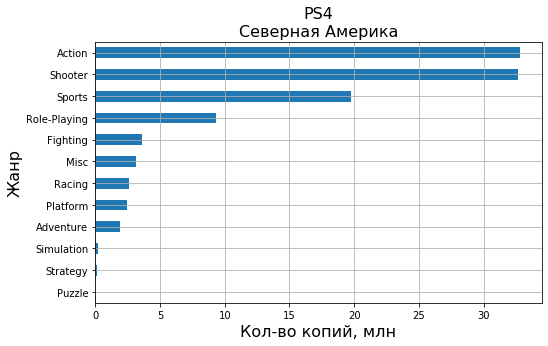

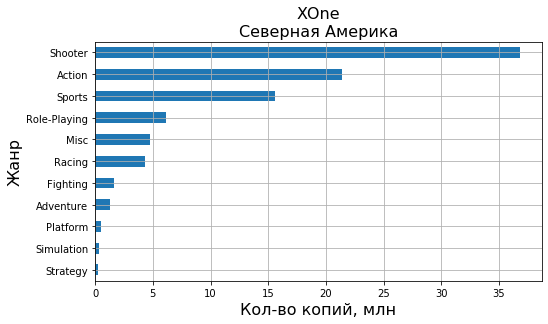

In [37]:
df_col_rating(df.query('2013<=year_of_release and platform=="PS4"'), 'genre', 'Кол-во копий, млн', 'Жанр','PS4\nСеверная Америка','na_sales')
df_col_rating(df.query('2013<=year_of_release and platform=="XOne"'), 'genre', 'Кол-во копий, млн', 'Жанр','XOne\nСеверная Америка','na_sales')

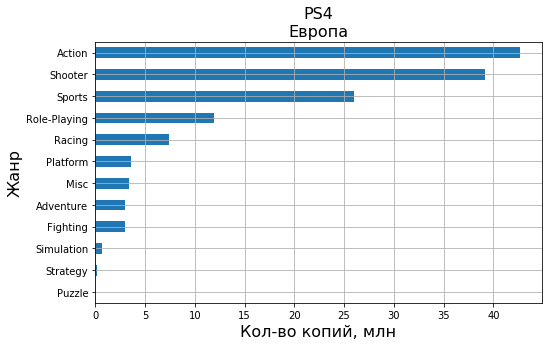

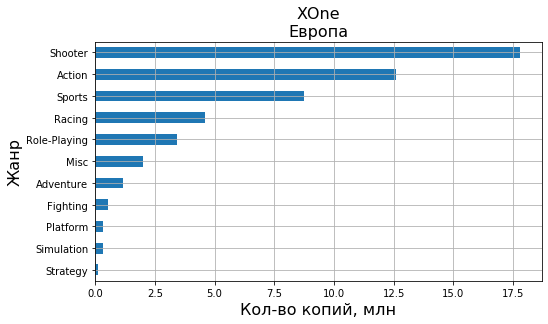

In [38]:
df_col_rating(df.query('2013<=year_of_release and platform=="PS4"'), 'genre', 'Кол-во копий, млн', 'Жанр','PS4\nЕвропа','eu_sales')
df_col_rating(df.query('2013<=year_of_release and platform=="XOne"'), 'genre', 'Кол-во копий, млн', 'Жанр','XOne\nЕвропа','eu_sales')

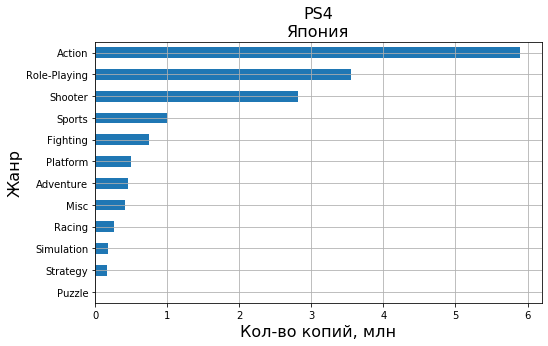

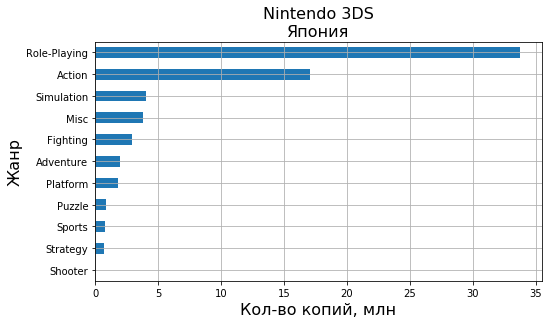

In [39]:
df_col_rating(df.query('2013<=year_of_release and platform=="PS4"'), 'genre', 'Кол-во копий, млн', 'Жанр','PS4\nЯпония','jp_sales')
df_col_rating(df.query('2013<=year_of_release and platform=="3DS"'), 'genre', 'Кол-во копий, млн', 'Жанр','Nintendo 3DS\nЯпония','jp_sales')

Заодно оценим целевую возрастную аудторию:

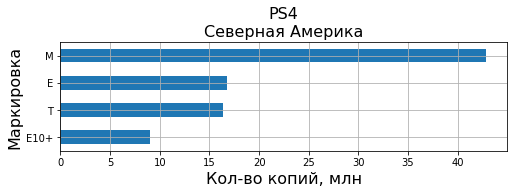

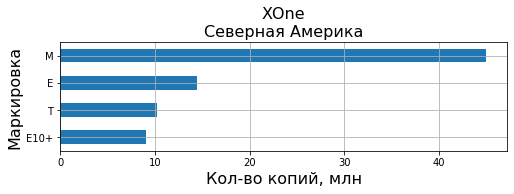

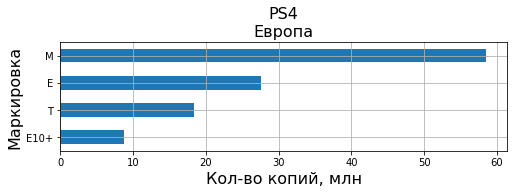

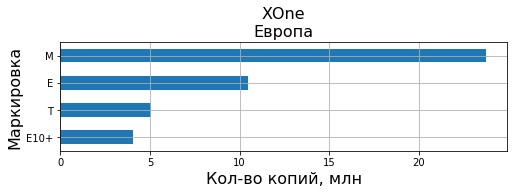

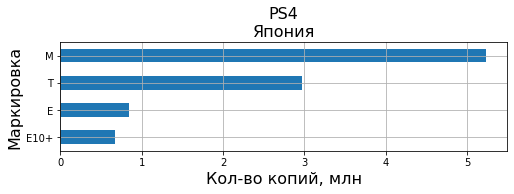

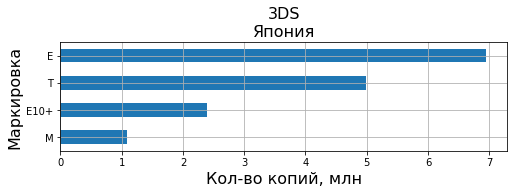

In [40]:
df_col_rating(df.query('2013<=year_of_release and platform=="PS4"'), 'rating', 'Кол-во копий, млн', 'Маркировка','PS4\nСеверная Америка','na_sales')
df_col_rating(df.query('2013<=year_of_release and platform=="XOne"'), 'rating', 'Кол-во копий, млн', 'Маркировка','XOne\nСеверная Америка','na_sales')
df_col_rating(df.query('2013<=year_of_release and platform=="PS4"'), 'rating', 'Кол-во копий, млн', 'Маркировка','PS4\nЕвропа','eu_sales')
df_col_rating(df.query('2013<=year_of_release and platform=="XOne"'), 'rating', 'Кол-во копий, млн', 'Маркировка','XOne\nЕвропа','eu_sales')
df_col_rating(df.query('2013<=year_of_release and platform=="PS4"'), 'rating', 'Кол-во копий, млн', 'Маркировка','PS4\nЯпония','jp_sales')
df_col_rating(df.query('2013<=year_of_release and platform=="3DS"'), 'rating', 'Кол-во копий, млн', 'Маркировка','3DS\nЯпония','jp_sales')

Похоже, жанровые предпочтения обуславливают выбор консоли. Действительно — довольно глупо получается покупать PlayStation 4 со всеми её шутерами, когда всю жизнь мечтал обустраивать остров в Animal Crossing.
Аналогично и отношение к наполнению игр: покупатели PS4 и Xbox One в основном предпочитают игры из категории 17+, которые содержат довольно много непристойных и жестоких эпизодов с кровью, убийствами и действиями сексуального характера.
Аудитория Nintendo 3DS в основном предпочитает игры из категории E или T.

<a id="Проверка"></a>
### [Проверка гипотез](#Содержание)
Обе гипотезы, которые мы должны проверить, подразумевают сравнение средних значений двух независимых выборок. Поэтому воспользуемся t-критерием Стьюдента.

In [41]:
#для корректной работы избавимся от NaN в столбце user_score
df_without_nan=df.query('2013<=year_of_release')
df_without_nan=df_without_nan[~df_without_nan['user_score'].isna()]

**Гипотеза о пользовательских оценках Xbox One и PC:**
- Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые  
- Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC различны

Для начала на всякий случай взглянем на распределение оценок:

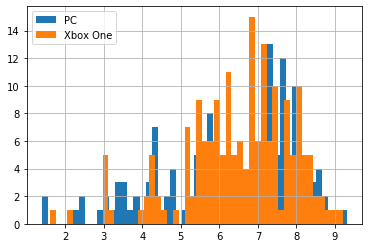

In [42]:
df_without_nan.query('platform=="XOne" or platform=="PC"').groupby('platform')['user_score'].hist(bins=50)
plt.legend(('PC','Xbox One'))

Оба распределения похожи на нормальные.

In [43]:
print('Средняя пользовательская оценка XOne: {:.2f}'.format(df_without_nan.query('platform=="XOne"')['user_score'].mean()))
print('Средняя пользовательская оценка PC: {:.2f}'.format(df_without_nan.query('platform=="PC"')['user_score'].mean()))
# критический уровень статистической значимости
alpha = 0.01
# проверка гипотезы о равенстве средних
results = st.ttest_ind(df_without_nan.query('platform=="XOne"')['user_score'],df_without_nan.query('platform=="PC"')['user_score'])
print('p-value:',results.pvalue) #p-value
if results.pvalue<alpha:
    print('Нулевая гипотеза не верна')
else:
    print('Не удалось опровергнуть нулевую гипотезу')


Средняя пользовательская оценка XOne: 6.52
Средняя пользовательская оценка PC: 6.27
p-value: 0.14012658403611647
Не удалось опровергнуть нулевую гипотезу


Вероятность того, что среднее значение пользовательских оценок в этих выборках отличаются по случайному стечению обстоятельств достаточно высока (~14%). А потому мы не можем утверждать, что средние оценцки пользователей Xbox One отличаются от пользователей ПК.

**Гипотеза о пользовательских оценках Action и Sports:**
- Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports одинаковы.  
- Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports разные.

Построим распределение оценок:

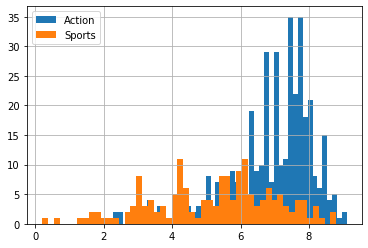

In [44]:
df_without_nan.query('genre=="Action" or genre=="Sports"').groupby('genre')['user_score'].hist(bins=50)
plt.legend(('Action','Sports'))

In [45]:
print('Средняя пользовательская оценка игр жанра Action: {:.2f}'.format(df_without_nan.query('genre=="Action"')['user_score'].mean()))
print('Средняя пользовательская оценка игр жанра Sports: {:.2f}'.format(df_without_nan.query('genre=="Sports"')['user_score'].mean()))
# критический уровень статистической значимости
alpha = 0.01
# проверка гипотезы о равенстве средних
results = st.ttest_ind(df_without_nan.query('genre=="Action"')['user_score'],df_without_nan.query('genre=="Sports"')['user_score'])
print('p-value:',results.pvalue) #p-value
if results.pvalue<alpha:
    print('Нулевая гипотеза не верна')
else:
    print('Не удалось опровергнуть нулевую гипотезу')


Средняя пользовательская оценка игр жанра Action: 6.84
Средняя пользовательская оценка игр жанра Sports: 5.24
p-value: 1.0517832389140023e-27
Нулевая гипотеза не верна


Похоже, нулевая гипотеза не верна и оценки жанров все-таки отличаются.

## [Выводы](#Содержание)
- В качестве потенциально прибыльных платформ можно назвать ***PlayStation 4***, ***Xbox One*** и ***Nintendo 3DS***
- Пользователи в разных регионах предпочитают разные платформы:
    - **в Европе** доминирует ***PlayStation 4***, а так же польуется спросом *Xbox One*
    - **в Северной Америке** ***PlayStation 4*** и ***Xbox One***
    - **в Японии** ***Nintendo 3DS***, а также пользуется спросом *PlayStation 4*
- Рекомендуемый жанр игр (как и возрастная маркировка) зависит от того, какой тип консоли пользуется популярностью в регионе. В порядке убывания популярности:
    - ***PlayStation 4:*** Action, Shooter, Sport, Role-Playing
    - ***Xbox One:*** Shooter, Action, Sport, Role-Playing
    - ***Nintendo 3DS:*** Role-Playing, Action
- Покупатели ***PlayStation 4*** и ***Xbox One*** предпочитают игры с рейтингом M, в то время как пользователи ***Nintendo 3DS*** - E.
- Стоит также отметить, что в Европе пользуется большим спросом линейка игр **FIFA** и играют в неё на PlayStation 4.
- Спрогнозировать продажи опираясь на оценки критиков весьма затруднительно.